Aim: Run random projection on pbmc dataset and test collapsing cells using annoy.



In [1]:
from util._io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
import fastsca
import logging

In [2]:
experiment = '/projects/experiments/fastsca/'
# experiment = sys.argv[1]

server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

Create an object to read data (scipy csr format).

In [3]:
sca = fastsca.FASTSCA()
sca.config = args
sca.initdata()
sca.loaddata()

## Random Projection

Johnson-Lindenstrauss Lemma-
The distance between two points in a high-dimension data is approximately preserved when projected onto a randomly selected subspace of suitable dimension.

$$X_{k \times N}^{RP} =  R_{k \times d} X_{d \times N}$$

Complexity : RP vs PCA
$$O(kdN)$$
$$O(d^{2}N + d^{3}+ kdN)$$

Non orthogonal transformation can significantly distort data.

R is generally not orthogonal and computation to orthogonalize R is expensive.

Hecht-Nielsen study - 
In a high-dimensional space, there exists a much larger number of almost orthogonal than orthogonal directions. Vectors having random directions might be sufficiently close to orthogonal.

$$R^{T}R \sim I$$

How to calculate number of reduced dimension:
$$k>ln(N)/ \epsilon^{2}$$

Gaussian random projection: $N(0,1/k)$



In [4]:
from sklearn import random_projection
from sklearn.preprocessing import StandardScaler

print(sca.data.mtx.shape)
transformer = random_projection.GaussianRandomProjection(eps=0.1)
x_r_n = transformer.fit_transform(np.asarray(sca.data.mtx))
print(x_r_n.shape)

# scaling data to zero mean and unit variance
scaler = StandardScaler()
x_r_n = scaler.fit_transform(x_r_n)

(2700, 13745)
(2700, 6772)


In [5]:
fpath = sca.config.home + sca.config.experiment +sca.config.output + sca.config.sample_id+'/'+sca.config.sample_id

## Collapsing cells into groups using greedy algorithm-

We want to obtain entire hyperplane bounded region of a query point in the annoy forest as our collapsing region.

1. First, we get any random cell and query its neighbors. This set will be the first collapsed entry in a dictionary. We will mark all the point in this region as "occupied" points.

2. Shuffle and pick next point and its neighbors. 
    If all neighbors ( size equal to the user input neighbor size) are not "occupied" then mark this as new collapsing space in a dictionary.
	If any neighbor in this list are previously occupied then find the farthest neighbor and assign this entire list to its respective space.



https://www.microsoft.com/en-us/research/publication/how-to-partition-a-billion-node-graph/


In [8]:
import _neighbour

# nbrsize=int(x_r_n.shape[0]*0.1)
nbrsize= 5
sample_ratio = 1
collapsed_dict, cells_used = _neighbour.get_collapsed_neighbors_greedy(x_r_n,sca.data.rows,nbrsize,sample_ratio)


collapsing... 5
collapsing... 1001
collapsing... 2001


In [9]:
print(len(collapsed_dict))

for k in collapsed_dict.keys():
    print(k,len(collapsed_dict[k]))


72
1652 108
1191 64
1796 61
1202 262
2250 20
2602 21
554 53
146 179
909 18
1519 28
2580 56
2465 12
2433 44
864 49
224 29
410 107
2023 26
2068 46
450 18
1138 20
1024 27
1195 248
891 5
1942 132
1307 56
2506 56
2417 9
1949 24
44 36
1854 7
849 33
1391 9
2688 38
1326 46
1266 27
2535 8
2224 16
2251 50
586 19
1500 25
793 66
643 13
1240 21
1983 28
1331 29
1761 14
652 41
1131 20
630 10
1987 38
1235 22
2666 15
648 13
788 44
2542 19
2668 19
255 11
1220 11
61 32
2369 5
32 10
1774 8
480 35
659 6
1628 14
1743 21
2495 15
413 5
380 6
215 5
2444 5
449 7


In [10]:
import gzip
with gzip.open(fpath+"_rp_bulk_dict.txt.gz", 'wt') as f: 
    for key, value in collapsed_dict.items(): 
        f.write('%s:%s\n' % (key, value))

In [15]:
import importlib
importlib.reload(_neighbour)

<module '_neighbour' from '/home/BCCRC.CA/ssubedi/projects/experiments/fastsca/fastsca/_neighbour.py'>

In [11]:
fpath = sca.config.home + sca.config.experiment +sca.config.output + sca.config.sample_id+'/'+sca.config.sample_id

dfp = pd.read_csv(fpath+'_prior_label.csv.gz')


dp = {}
for idx,row in dfp.iterrows():
    if row[1] in dp:
        dp[row[1]].append(row[0])
    else:
        dp[row[1]] = [row[0]]
        
for k in dp.keys():print(k,len(dp[k]))


1 515
3 341
5 192
6 163
0 638
4 295
2 445
7 36
8 13


In [12]:
rp_count = []
for chk_indx in collapsed_dict.keys(): 
    cells = pd.DataFrame(sca.data.rows).iloc[collapsed_dict[chk_indx]].values.flatten()
    prior_count = []
    for k in dp.keys():
        count = 0
        for c in cells:
            if c in dp[k]: count += 1
        prior_count.append(count)
    rp_count.append(prior_count)

df_res = pd.DataFrame(rp_count)
df_res.columns = dp.keys()
df_res.index = collapsed_dict.keys()    

In [13]:
print(df_res)
df_res = df_res.div(df_res.sum(axis=1), axis=0)

        1   3  5   6    0   4  2  7  8
1652   14  13  0  11   31  27  1  0  0
1191   22   0  0   0   41   1  0  0  0
1796   24   5  0   1   18  13  0  0  0
1202  101  19  0   2  109  24  0  6  0
2250   12   0  0   0    4   4  0  0  0
...   ...  .. ..  ..  ...  .. .. .. ..
413     3   1  0   0    1   0  0  0  0
380     0   0  0   0    0   0  0  6  0
215     0   0  0   0    1   4  0  0  0
2444    4   0  0   0    1   0  0  0  0
449     3   2  0   0    1   0  0  0  0

[72 rows x 9 columns]


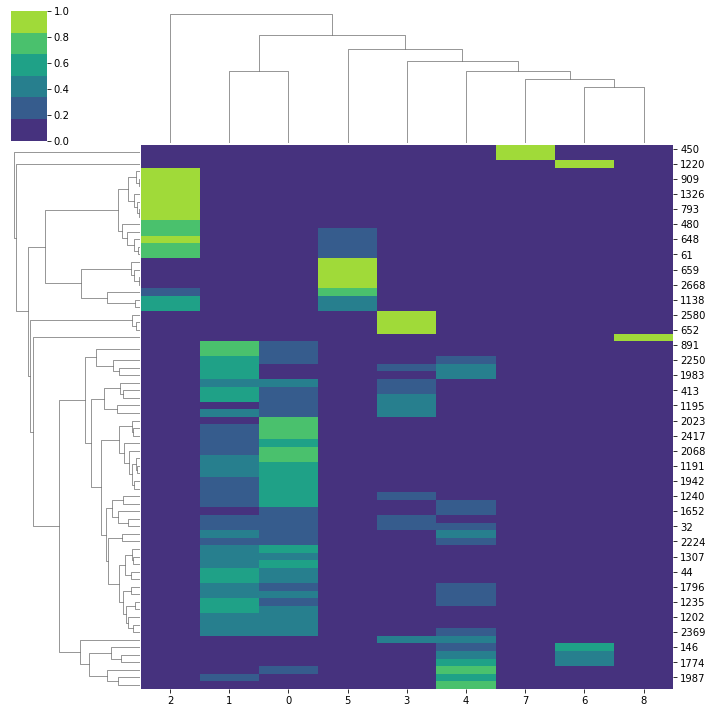

In [14]:
import matplotlib.pylab as plt
import seaborn as sns

sns.clustermap(df_res,cmap=sns.color_palette('viridis'))

In [15]:
# read collapsed dictionary and construct collapsed expression matrix

bulk = {}
for key, value in collapsed_dict.items(): 
    bulk[key] = np.asarray(sca.data.mtx[value].mean(0))[0]

pd.DataFrame.from_dict(bulk,orient='index').reset_index().to_csv(fpath+"_rp_bulk.csv.gz",compression='gzip',index=False)

In [ ]:
df = pd.read_csv(fpath+"_rp_bulk.csv.gz")

In [ ]:
df.shape